In [ ]:

url_list = ['https://www.currentresults.com/Weather/US/humidity-city-march.php',
            'http://18.216.124.216:3838/COVID-Tracker/',
            'https://www.linkedin.com/pulse/effect-temperature-humidity-growth-rate-covid-19-charles-wiles/',
            'https://www.worldometers.info/coronavirus/#countries', 'https://www.timeanddate.com/weather/usa/marlborough',
            'https://github.com/nytimes/covid-19-data']
for url in url_list:
    !"C:\Program Files (x86)\Google\Chrome\Application\chrome.exe" {url}

In [1]:

import sys

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

In [2]:

%run ../../load_magic/storage.py
%run ../../load_magic/paths.py
%run ../../load_magic/lists.py
%run ../../load_magic/environment.py
%run ../../load_magic/dataframes.py

import scraping_utils
wikipedia = scraping_utils.wikipedia

from bs4 import BeautifulSoup as bs
import networkx as nx
import re
import urllib.request
import numpy as np

notebook_path = get_notebook_path()
print(notebook_path)
s = Storage()
#pandemic_df = s.load_object('pandemic_df')
print(['s.{}'.format(fn) for fn in dir(s) if not fn.startswith('_')])

%pprint
dir()

D:\Documents\Repositories\notebooks\covid19\ipynb\States Doubling Wind Release.ipynb
['s.attempt_to_pickle', 's.data_csv_folder', 's.data_folder', 's.encoding_type', 's.load_csv', 's.load_dataframes', 's.load_object', 's.save_dataframes', 's.saves_csv_folder', 's.saves_folder', 's.saves_pickle_folder', 's.store_objects']
Pretty printing has been turned OFF


['Config', 'In', 'Out', 'RandomForestClassifier', 'SequenceMatcher', 'Storage', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__nonzero__', '__package__', '__spec__', '__warningregistry__', '_dh', '_i', '_i1', '_i2', '_ih', '_ii', '_iii', '_oh', 'bs', 'check_4_doubles', 'check_for_typos', 'conjunctify_list', 'copyfile', 'csv', 'encoding', 'example_iterrows', 'exit', 'filepath_regex', 'get_classifier', 'get_column_descriptions', 'get_data_structs_dataframe', 'get_datastructure_prediction', 'get_dir_tree', 'get_git_lfs_track_commands', 'get_importances', 'get_input_sample', 'get_ipython', 'get_max_rsquared_adj', 'get_module_version', 'get_notebook_path', 'get_page_tables', 'get_specific_gitignore_files', 'get_struct_name', 'humanize_bytes', 'io', 'ipykernel', 'json', 'jupyter_config_dir', 'math', 'notebook_path', 'notebookapp', 'np', 'nx', 'os', 'pd', 'pickle', 'plt', 'preprocess_data', 'print_all_files_ending_starting_with', 'print_all_files_endi

In [3]:

def get_doubling_days(count_yesterday, count_today):
    growth_rate = (count_today-count_yesterday)/count_today
    doubling_days = math.log(2)/growth_rate
    
    return doubling_days


---
# Load the Data

In [4]:

from datetime import date
import numpy as np

# https://github.com/nytimes/covid-19-data/blob/master/us-states.csv
state_abbreviation_dict = s.load_object('state_abbreviation_dict')
repo_folder = r'D:\Documents\Repositories\covid-19-data'
csv_path = os.path.join(repo_folder, 'us-states.csv')
nytimes_covid_19_data_us_states_df = pd.read_csv(os.path.abspath(csv_path), encoding=s.encoding_type)
nytimes_covid_19_data_us_states_df.date = pd.to_datetime(nytimes_covid_19_data_us_states_df.date).map(lambda ts: date(ts.year,
                                                                                                                      ts.month, ts.day))
nytimes_covid_19_data_us_states_df = nytimes_covid_19_data_us_states_df.sort_values(['state', 'date'])
nytimes_covid_19_data_us_states_df.reset_index(level=0, inplace=True, drop=True)
for p in ['deaths', 'cases']:
    nytimes_covid_19_data_us_states_df['{}_doubling'.format(p)] = np.nan
for state_name in nytimes_covid_19_data_us_states_df.state.unique():
    mask_series = (nytimes_covid_19_data_us_states_df.state == state_name)
    row_index_list = nytimes_covid_19_data_us_states_df[mask_series].sort_values('date').index
    for p in ['deaths', 'cases']:
        for i in range(1, len(row_index_list)):
            row_index = row_index_list[i-1]
            count_yesterday = nytimes_covid_19_data_us_states_df.loc[row_index, p]
            row_index = row_index_list[i]
            count_today = nytimes_covid_19_data_us_states_df.loc[row_index, p]
            doubling_days = get_doubling_days(count_yesterday, count_today)
            if abs(doubling_days) != np.inf:
                nytimes_covid_19_data_us_states_df.loc[row_index, '{}_doubling'.format(p)] = doubling_days
nytimes_covid_19_data_us_states_df = nytimes_covid_19_data_us_states_df.replace([np.inf, -np.inf], np.nan)
nytimes_covid_19_data_us_states_df['label'] = nytimes_covid_19_data_us_states_df.state.map(lambda x: state_abbreviation_dict[x])
s.store_objects(nytimes_covid_19_data_us_states_df=nytimes_covid_19_data_us_states_df)
nytimes_covid_19_data_us_states_df.tail(5)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\nytimes_covid_19_data_us_states_df.pickle


,date,state,fips,cases,deaths,deaths_doubling,cases_doubling,label
2492,2020-04-12,Wyoming,56,270,0,NaN,20.794415,WY
2493,2020-04-13,Wyoming,56,275,1,0.693147,38.123095,WY
2494,2020-04-14,Wyoming,56,282,1,NaN,27.923929,WY
2495,2020-04-15,Wyoming,56,288,2,1.386294,33.271065,WY
2496,2020-04-16,Wyoming,56,296,2,NaN,25.646446,WY


In [5]:

def compare_smoothed(state_name):
    fig = plt.figure(figsize=(18, 8))
    ax = fig.add_subplot(111, autoscale_on=True)
    Text_obj = ax.set_xlabel('Doubling Period (Days/Smoothed)')
    for column_name in ['deaths_doubling', 'dd_smoothed']:
        mask_series = (nytimes_covid_19_data_us_states_df.state == state_name)
        df = nytimes_covid_19_data_us_states_df[mask_series].sort_values('date')
        if 'smoothed' in column_name:
            AxesSubplot_obj = df.plot.scatter(x='date', y=column_name, ax=ax, label=column_name,
                                              color='red', s=2.0)
        else:
            AxesSubplot_obj = df.plot.line(x='date', y=column_name, ax=ax, label=column_name)

In [23]:

def f(df):
    columns_list = ['deaths_doubling']
    df = df.sort_values('date', ascending=True)[columns_list]
    #unsmoothed_series = df.deaths_doubling
    df = df.interpolate(axis='index', limit_area='inside', inplace=False)
    interpolated_series = df.deaths_doubling
    smoothed_series = interpolated_series.rolling(3).mean().combine_first(interpolated_series)
    doublings_series = pd.concat([interpolated_series, smoothed_series], axis=1).min(axis=1)
    
    return smoothed_series

nytimes_covid_19_data_us_states_df['dd_smoothed'] = nytimes_covid_19_data_us_states_df.groupby('state').apply(f).reset_index(level=0,
                                                                                                                             drop=True)
s.store_objects(nytimes_covid_19_data_us_states_df=nytimes_covid_19_data_us_states_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\nytimes_covid_19_data_us_states_df.pickle


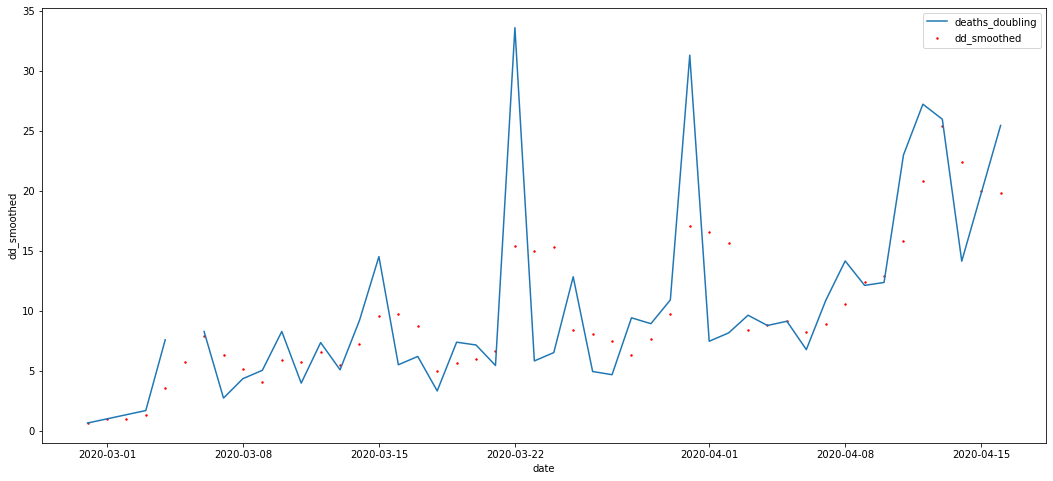

In [7]:

compare_smoothed('Washington')

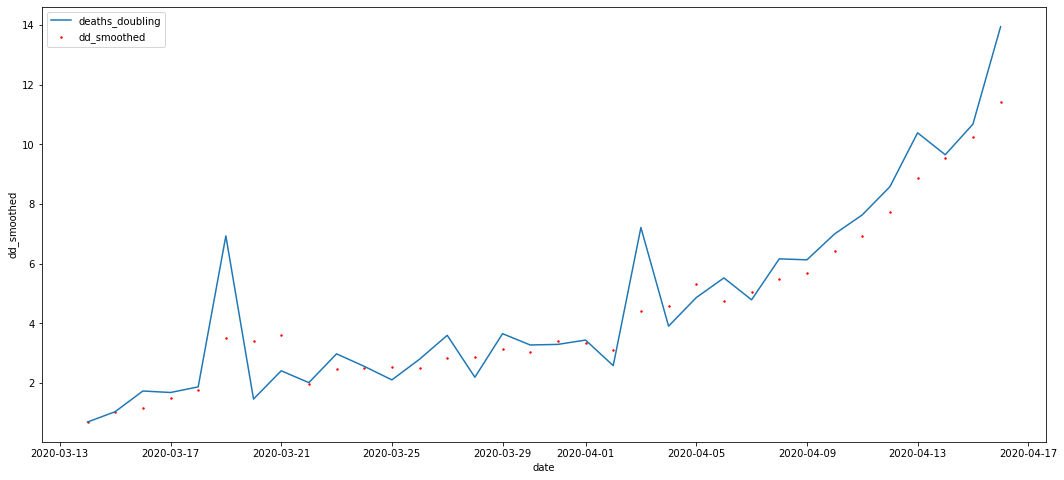

In [8]:

compare_smoothed('New York')

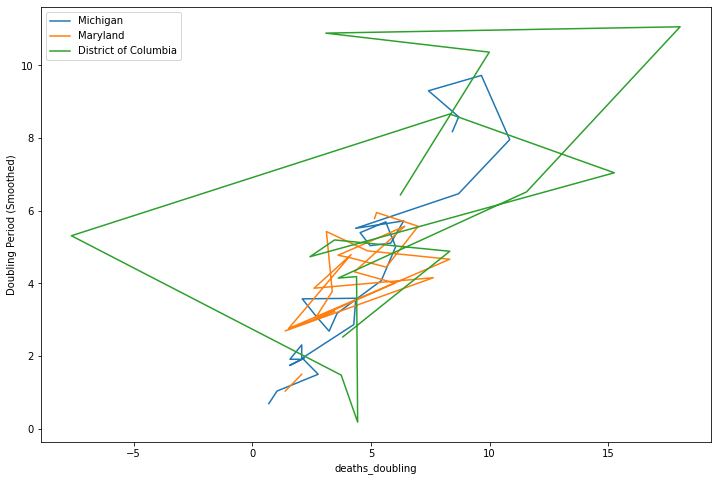

In [9]:

columns_list = ['deaths_doubling', 'dd_smoothed']
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, autoscale_on=True)
Text_obj = ax.set_xlabel('Doubling Period (Days)')
Text_obj = ax.set_ylabel('Doubling Period (Smoothed)')
states_list = nytimes_covid_19_data_us_states_df.state.unique()
for state_name in np.random.choice(states_list, size=3):
    mask_series = (nytimes_covid_19_data_us_states_df.state == state_name)
    df = nytimes_covid_19_data_us_states_df[mask_series].sort_values('date')[columns_list]
    AxesSubplot_obj = df.plot.line(x='deaths_doubling', y='dd_smoothed', ax=ax, label=state_name)

In [10]:

from matplotlib.patches import Rectangle

xlim_left = -1
xlim_right = 15
ylim_top = 1_000_000
doubling_match_series = (nytimes_covid_19_data_us_states_df.deaths > 0) & (nytimes_covid_19_data_us_states_df.dd_smoothed > 0)
doubling_match_series = doubling_match_series & (nytimes_covid_19_data_us_states_df.deaths <= ylim_top)
doubling_match_series = doubling_match_series & (nytimes_covid_19_data_us_states_df.dd_smoothed <= xlim_right)
ylim_bottom = nytimes_covid_19_data_us_states_df[doubling_match_series].deaths.min()
png_dir = os.path.join(s.saves_folder, 'png')
dates_list = [date(ts.year, ts.month,
                   ts.day) for ts in pd.date_range(nytimes_covid_19_data_us_states_df[doubling_match_series].date.min(),
                                                   nytimes_covid_19_data_us_states_df[doubling_match_series].date.max())]
bottom = 100
red_left = 0
red_kwargs = {'alpha': 0.25, 'edgecolor': 'black', 'facecolor': 'pink',
              'fill': True, 'label': 'Pandemic Zone', 'zorder': 1}
yellow_left = 8
yellow_kwargs = {'alpha': 0.25, 'edgecolor': 'black', 'facecolor': 'yellow',
                 'fill': True, 'label': 'Flattened Zone', 'zorder': 2}

In [11]:

def create_figure(date_obj):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, autoscale_on=False)
    ax.set_yscale('log')
    xlim_tuple = ax.set_xlim(left=xlim_left, right=xlim_right)
    ylim_tuple = ax.set_ylim(bottom=ylim_bottom, top=ylim_top)
    Text_obj = ax.set_xlabel('Doubling Period (Days)')
    Text_obj = ax.set_ylabel('New Deaths')
    Text_obj = ax.set_title('COVID-19 Outbreak {}'.format(date_obj))
    
    # Danger Zone
    Rectangle_obj = ax.add_patch(Rectangle(xy=(red_left, bottom), width=6,
                                           height=ylim_top-bottom, angle=0.0,
                                           **red_kwargs))
    kwargs = {'horizontalalignment': 'center', 'verticalalignment': 'center',
              'transform': ax.transAxes, 'color': 'red', 'alpha': 1.0}
    fig.text(0.245, 0.95,
             'Danger Zone:\nAlarming Doubling Period and\nHigh number of new deaths',
             **kwargs)
    
    # Flattened Zone
    Rectangle_obj = ax.add_patch(Rectangle(xy=(yellow_left, bottom), width=6,
                                           height=ylim_top-bottom, angle=0.0,
                                           **yellow_kwargs))
    kwargs = {'horizontalalignment': 'center', 'verticalalignment': 'center',
              'transform': ax.transAxes, 'color': 'black', 'alpha': 1.0}
    fig.text(0.745, 0.95,
             'Warning Zone:\nSlowing down the Doubling Period\ndue to Flattening the Curve',
             **kwargs)
    
    return fig, ax

In [16]:

state_abbreviation_dict = s.load_object('state_abbreviation_dict')
state_abbreviation_dict

{'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'District of Columbia': 'DC', 'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY', 'American Samoa': 'AS', 'Guam': 'GU', 'Northern

In [19]:

import matplotlib.pyplot as plt

# Turn interactive plotting off
fig, ax = plt.subplots(figsize=(1, 1))
plt.ioff()

nytimes_covid_19_data_us_states_df = s.load_object('nytimes_covid_19_data_us_states_df')
color_dict = {}
states_abbreviation_color_dict = {}
for state_name in nytimes_covid_19_data_us_states_df.groupby('state').deaths.max().sort_values(ascending=False).index:
    mask_series = (nytimes_covid_19_data_us_states_df.state == state_name)
    df = nytimes_covid_19_data_us_states_df[mask_series]
    deaths_series = df.deaths
    doublings_series = df.deaths_doubling
    Line2D_obj = ax.plot(deaths_series, doublings_series, label=state_name)[0]
    color = Line2D_obj.get_color()
    color_dict[state_name] = color
    state_abbreviation = state_abbreviation_dict[state_name]
    states_abbreviation_color_dict[state_abbreviation] = color
s.store_objects(states_color_dict=color_dict, states_abbreviation_color_dict=states_abbreviation_color_dict)
plt.close(fig)
states_abbreviation_color_dict

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\states_color_dict.pickle
Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\states_abbreviation_color_dict.pickle


{'NY': '#1f77b4', 'NJ': '#ff7f0e', 'MI': '#2ca02c', 'MA': '#d62728', 'LA': '#9467bd', 'IL': '#8c564b', 'CA': '#e377c2', 'CT': '#7f7f7f', 'PA': '#bcbd22', 'FL': '#17becf', 'GA': '#1f77b4', 'WA': '#ff7f0e', 'IN': '#2ca02c', 'TX': '#d62728', 'OH': '#9467bd', 'CO': '#8c564b', 'MD': '#e377c2', 'VA': '#7f7f7f', 'WI': '#bcbd22', 'MO': '#17becf', 'AZ': '#1f77b4', 'TN': '#ff7f0e', 'NV': '#2ca02c', 'NC': '#d62728', 'AL': '#9467bd', 'OK': '#8c564b', 'KY': '#e377c2', 'MS': '#7f7f7f', 'SC': '#bcbd22', 'RI': '#17becf', 'MN': '#1f77b4', 'DC': '#ff7f0e', 'KS': '#2ca02c', 'OR': '#d62728', 'IA': '#9467bd', 'PR': '#8c564b', 'DE': '#e377c2', 'NM': '#7f7f7f', 'ID': '#bcbd22', 'AR': '#17becf', 'VT': '#1f77b4', 'NH': '#ff7f0e', 'ME': '#2ca02c', 'NE': '#d62728', 'UT': '#9467bd', 'WV': '#8c564b', 'HI': '#e377c2', 'ND': '#7f7f7f', 'SD': '#bcbd22', 'MT': '#17becf', 'AK': '#1f77b4', 'GU': '#ff7f0e', 'MP': '#2ca02c', 'WY': '#d62728', 'VI': '#9467bd', 'AS': '#8c564b'}

In [13]:

for date_obj in dates_list:
    fig, ax = create_figure(date_obj)
    mask_series = (nytimes_covid_19_data_us_states_df.date == date_obj) & doubling_match_series
    df = nytimes_covid_19_data_us_states_df[mask_series].copy()
    for state_name in df.state:
        mask_series = (df.state == state_name)
        deaths_series = df[mask_series].deaths
        doublings_series = df[mask_series].dd_smoothed
        kwargs = dict(textcoords='offset points', ha='left', va='bottom',
                      bbox=dict(boxstyle='round,pad=0.5', fc=color_dict[state_name], alpha=0.5))
        PathCollection_obj = ax.scatter(x=doublings_series, y=deaths_series, s=0.0, c=color_dict[state_name], alpha=0.0)
        for x, y in zip(doublings_series, deaths_series):
            annotation = plt.annotate('{}'.format(state_abbreviation_dict[state_name]), xy=(x, y), xytext=(-5, -8), **kwargs)
    file_name = 'fig_{}_{:02d}_{:02d}.png'.format(date_obj.year, date_obj.month, date_obj.day)
    fig.savefig(os.path.join(png_dir, file_name), transparent=False)
    plt.close(fig)

In [14]:

import imageio

# Get images list
images_list = []
for date_obj in dates_list:
    file_name = 'fig_{}_{:02d}_{:02d}.png'.format(date_obj.year, date_obj.month, date_obj.day)
    file_path = os.path.join(png_dir, file_name)
    images_list.append(imageio.imread(file_path))
for i in range(9):
    images_list.append(imageio.imread(file_path))

In [21]:

gif_dir = os.path.join(s.saves_folder, 'gif')
os.makedirs(name=gif_dir, exist_ok=True)
file_path = os.path.join(gif_dir, 'new_deaths_by_state.gif')
kwargs = {'duration': 1}
imageio.mimsave(file_path, images_list, **kwargs)

In [22]:

!"C:\Program Files (x86)\Google\Chrome\Application\chrome.exe" {os.path.abspath(file_path)}

Opening in existing browser session.

C:\Program Files (x86)\Google\Chrome\Application\chrome.exe: invalid option -- `-u'
Try 'chrome.exe --help' for more information.
[0417/193404.270:ERROR:registration_protocol_win.cc(84)] TransactNamedPipe: The pipe has been ended. (0x6D)
[111556:25000:0417/193404.642:ERROR:cache_util_win.cc(21)] Unable to move the cache: Access is denied. (0x5)
[111556:25000:0417/193404.642:ERROR:cache_util.cc(135)] Unable to move cache folder C:\Users\577342\AppData\Local\Google\Chrome\User Data\ShaderCache\GPUCache to C:\Users\577342\AppData\Local\Google\Chrome\User Data\ShaderCache\old_GPUCache_000
[111556:25000:0417/193404.642:ERROR:disk_cache.cc(184)] Unable to create cache
[111556:25000:0417/193404.642:ERROR:shader_disk_cache.cc(606)] Shader Cache Creation failed: -2


In [17]:

text_editor_path = r'C:\Program Files\Notepad++\notepad++.exe'
!"{text_editor_path}" "{csv_path}"

In [18]:

!start %windir%\explorer.exe "{os.path.dirname(os.path.abspath(file_path))}"


---

In [ ]:

def compare_smoothed_twinx(state_name):
    fig = plt.figure(figsize=(18, 8))
    ax1 = plt.plot()
    mask_series = (nytimes_covid_19_data_us_states_df.state == state_name)
    columns_list = ['date', 'deaths_doubling', 'dd_smoothed']
    df = nytimes_covid_19_data_us_states_df[mask_series].sort_values('date')[columns_list]
    t = df.date
    s1 = df.deaths_doubling
    plt.plot(t, s1, 'b-')
    plt.xlabel('Date')
    plt.ylabel('Doubling Period (Days)', color='b')

    ax2 = plt.gca().twinx()
    s2 = df.dd_smoothed
    ax2.plot(t, s2, 'r.')
    ylabel_Text = plt.ylabel('Doubling Period (Smoothed)', color='r')

In [13]:

us_states_df = s.load_object('states_stats_df')
print([cn for cn in us_states_df.columns if 'abbrev' in cn.lower()])

['district_abbreviation', 'State_Abbreviation']


In [15]:

us_states_df = s.load_object('states_stats_df')
state_abbreviation_dict = us_states_df.State_Abbreviation.to_dict()
state_abbreviation_dict['American Samoa'] = 'AS'
state_abbreviation_dict['District of Columbia'] = 'DC'
state_abbreviation_dict['Guam'] = 'GU'
state_abbreviation_dict['Northern Mariana Islands'] = 'MP'
state_abbreviation_dict['Puerto Rico'] = 'PR'
state_abbreviation_dict['Virgin Islands'] = 'VI'
s.store_objects(state_abbreviation_dict=state_abbreviation_dict)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\state_abbreviation_dict.pickle


In [ ]:

rows_list = []
color_dict = s.load_object('color_dict')
for state_name, abbreviation in state_abbreviation_dict.items():
    row_dict = {}
    row_dict['state_name'] = state_name
    row_dict['abbreviation'] = abbreviation
    if state_name in color_dict:
        row_dict['color'] = color_dict[state_name]
    rows_list.append(row_dict)
state_colors_df = pd.DataFrame(rows_list)
s.save_dataframes(state_colors_df=state_colors_df)


---
# Geometric Brownian motion

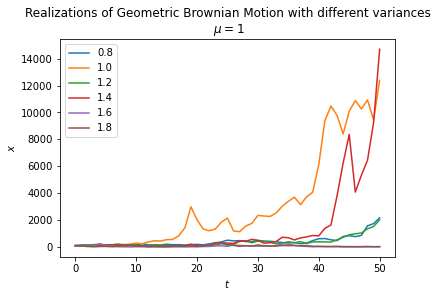

In [3]:

# Python code for the plot
%matplotlib inline
import numpy as np

mu = 1
n = 50
dt = 0.1
x0 = 100
np.random.seed(1)

sigma = np.arange(0.8, 2, 0.2)

x = np.exp(
    (mu - sigma ** 2 / 2) * dt +
    sigma * np.random.normal(0, np.sqrt(dt), size=(len(sigma), n)).T)
x = np.vstack([np.ones(len(sigma)), x])
x = x0 * x.cumprod(axis=0)

plt.plot(x)
plt.legend(np.round(sigma, 2))
plt.xlabel('$t$')
plt.ylabel('$x$')
Text_obj = plt.title('Realizations of Geometric Brownian Motion with different variances\n $\mu=1$')


---
# Humidity

In [140]:

!start %windir%\explorer.exe "{os.path.abspath(gif_dir)}"

In [12]:

file_path = os.path.join(s.data_folder, 'xlsx', 'humidity-city-march.xlsx')
#tables_url = 'https://www.currentresults.com/Weather/US/humidity-city-march.php'
humidity_city_march_df = pd.read_excel(file_path)

In [46]:

# https://www.currentresults.com/Weather/US/annual-average-humidity-by-state.php
file_path = os.path.join(s.data_folder, 'xlsx', 'annual-average-humidity-by-state.xlsx')
humidity_state_annual_df = pd.read_excel(file_path)
mask_series = (humidity_state_annual_df.State == 'MassachuÂ\xadsetts')
humidity_state_annual_df.loc[mask_series, 'State'] = 'Massachusetts'
mask_series = (humidity_state_annual_df.State == 'ConnectiÂ\xadcut')
humidity_state_annual_df.loc[mask_series, 'State'] = 'Connecticut'
humidity_state_annual_df.set_index('State', drop=True, inplace=True)
humidity_dict = humidity_state_annual_df.Afternoon.to_dict()

In [48]:

set(cases_deaths_df.state) - set(humidity_state_annual_df.index)

{'District of Columbia', 'Puerto Rico', 'Virgin Islands', 'Guam', 'Northern Mariana Islands'}

In [47]:

set(humidity_state_annual_df.index) - set(cases_deaths_df.state)

set()

In [55]:

#state_groupby = cases_deaths_df.groupby('state')
#print(['state_groupby.cases.{}'.format(fn) for fn in dir(state_groupby.cases) if not fn.startswith('_')])
cases_lists_dict = {}
deaths_lists_dict = {}
for state_name in cases_deaths_df.state.unique():
    if state_name in humidity_dict:
        mask_series = (cases_deaths_df.state == state_name)
        cases_list = []
        deaths_list = []
        doy_list = []
        for row_index, row_series in cases_deaths_df[mask_series].sort_values('date').iterrows():
            cases = row_series.cases
            cases_list.append(cases*humidity_dict[state_name])
            deaths = row_series.deaths
            deaths_list.append(deaths*humidity_dict[state_name])
            doy = row_series.date.dayofyear
            doy_list.append(doy)
        cases_lists_dict[state_name] = (doy_list, cases_list)
        deaths_lists_dict[state_name] = (doy_list, deaths_list)

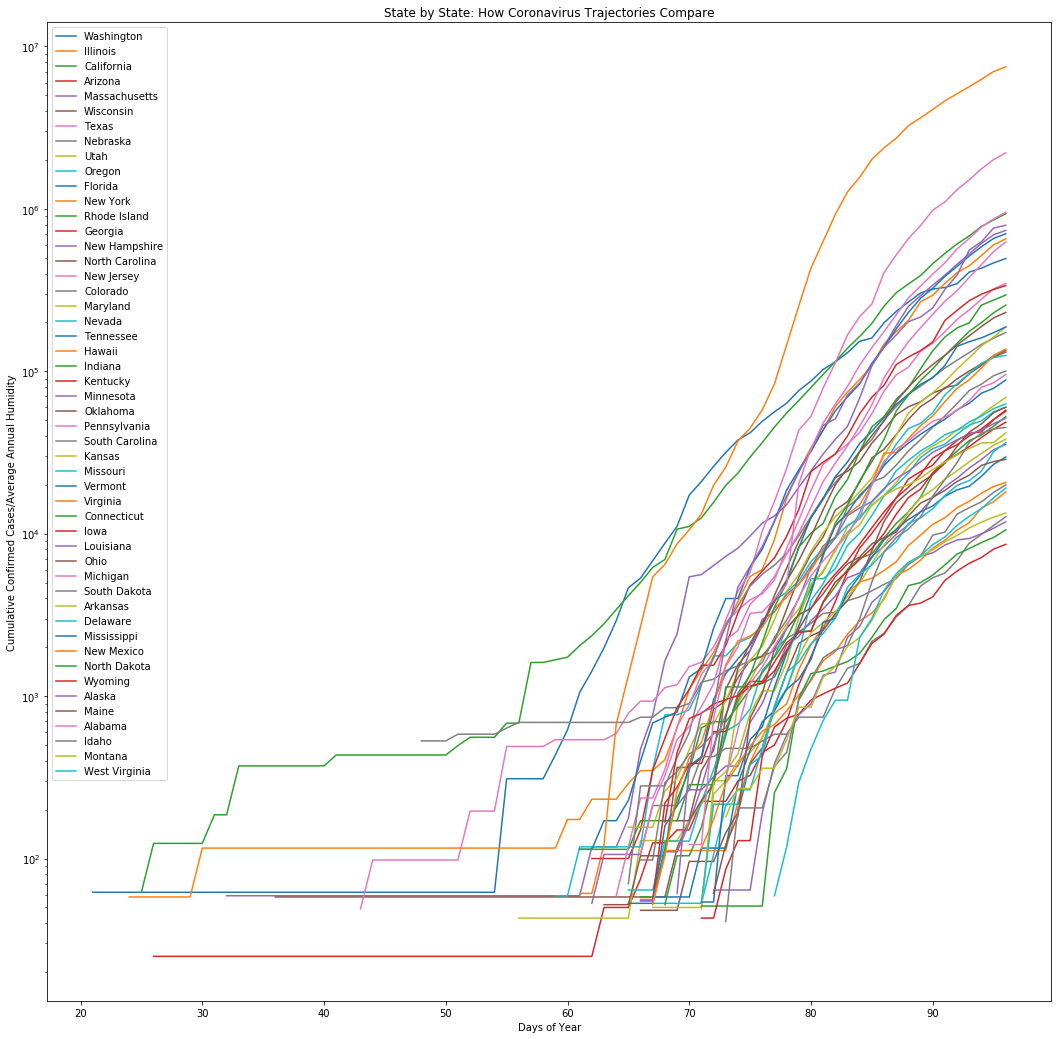

In [59]:

import math

fig, ax = plt.subplots(figsize=(18, 18))
ax.set_yscale('log')
ax.set_ylabel('Cumulative Confirmed Cases/Average Annual Humidity')
ax.set_xlabel('Days of Year')
ax.set_title('State by State: How Coronavirus Trajectories Compare')
for state_name, cases_tuple in cases_lists_dict.items():
    doy_list = cases_tuple[0]
    cases_list = cases_tuple[1]
    Line2D_obj = ax.plot(doy_list, cases_list, label=state_name)[0]
legend_obj = plt.legend()

In [18]:

humidity_city_march_df

,Daily,City,Morning,Afternoon
0,62,"Atlanta, Georgia",74,47
1,64,"Austin, Texas",80,48
2,59,"Baltimore, Maryland",68,47
3,64,"Birmingham, Alabama",79,47
4,63,"Boston, Massachusetts",69,56
5,73,"Buffalo, New York",79,65
6,62,"Charlotte, North Carolina",74,46
7,70,"Chicago, Illinois",79,59
8,67,"Cincinnati, Ohio",75,55
9,70,"Cleveland, Ohio",76,62
